# Kafka Customer - Model Performace and Retraining

A notebook that is used on the local machine to connect to the Kafka server and act as the consumer.

---

##### Libraries

In [3]:
# Libraries in the Consumer Notebook

# General
import time
import os
import sys

# Data manipulation
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# SQL
import pymysql
import mysql.connector

# Data types
import json
import joblib

# Avro objects
import io
import fastavro
import avro

# Kafka
from confluent_kafka import Consumer, KafkaException, KafkaError

# Machine Learning Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans # used to partial retrain models

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, silhouette_score

from skmultiflow.trees import HoeffdingTree

In [4]:
import warnings
warnings.filterwarnings('ignore')

---

# Outline Second Consumer for Testing Model Results and Retraining

This consumer needs to:
   - 1) Set up Kafka Consumer
       - 1.1) Load baseline model
       - 1.2) Load Schemas
   - 2) Read batches
   - 3) Deserailise the Data - using saved schema
   - 4) Load baseline model
   - 5) Test against baseline mode
       - 5.1) Send results to the SQL Database
   - 6) Retrain the model
       - 6.1) Send training time to SQL Database
   - 7) Take new batch and contuine iteration

## Set up Kafka Consumer

In [22]:
# ## Set up Kafka Consumer 
# conf = {
#     "bootstrap.servers":"localhost:9002",
#     "group.id":"jupyter-consumer-group",
#     "auto.offset.reset":"earliest"
# }

# consumer = Consumer(conf)
# consumer.subscribe(["batch-network-data", "test-batch-labels"])

### Load baseline model: CHANGE PER MODEL

In [58]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "rf_model_baseline_basic.joblib"

# Load RF baseline model
rf_model_baseline_basic = joblib.load(f"{model_folder_path}\\{model_name}")

### Load schemas

In [5]:
# function to load each scheam, features and label
def load_avro_schema_with_fastavro(schema_file_path):
    schema = fastavro.schema.load_schema(schema_file_path)
    return schema

# folder location and file names for the schema files
folder_path = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Avro Schema'
features_avro_schema_file = "features_avro_schema.avsc" 
label_avro_schema_file = "label_avro_schema.avsc"

# Each Schema is loaded
features_avro_schema = load_avro_schema_with_fastavro(os.path.join(folder_path ,features_avro_schema_file)) 
label_avro_schema = load_avro_schema_with_fastavro(os.path.join(folder_path, label_avro_schema_file))

### Create a function for deserialising avro objects

In [6]:
def deserialise_features_avro_record(avro_bytes, schema):
    bytes_reader = io.BytesIO(avro_bytes)
    deserialised_data = []
    for record in fastavro.reader(bytes_reader, reader_schema=schema):
        deserialised_data.append(record)
    return deserialised_data

def deserialise_label_avro_record(avro_bytes, schema):
    bytes_reader = io.BytesIO(avro_bytes)
    deserialised_data = []
    for record in fastavro.reader(bytes_reader, reader_schema=schema):
        deserialised_data.append(record)
    return deserialised_data

### Variables needed in notebook: CHANGE PER MODEL

In [5]:
# Location where avro files are saved from the Previous Consumer.
folder_path =r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

# Location to store updated retaind models
retrained_models_folder = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models\Real Time Batch Retained Models"

### Function to send resutls to SQL Database: CHANGE PER MODEL

In [7]:
# Connection details for SQL Database
config = {
    "user":"root",
    "password":"root",
    "host": "localhost",
    "database":"mtu_capstone_db",
    "raise_on_warnings":True
}

In [62]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, model_description, batch_number,
                                    accuracy_value, precision_value, recall_value, f1_value, 
                                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                                    model_training_time, model_paramaters_json, model_size):
    
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO rf_basic_rt_model_results
            (model_name, model_id, model_description, batch_number,
                    accuracy_value, precision_value, recall_value, f1_value, 
                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                    model_training_time, model_paramaters_json, model_size) 
            VALUES(%s, %s, %s, %s, %s, %s, %s, %s, 
                    %s, %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, model_description, batch_number,
                    accuracy_value, precision_value, recall_value, f1_value, 
                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                    model_training_time, model_paramaters_json, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")


---

# **Consumer 1.1 - Random Forest**

In [240]:
############################################################
# Random Froest Basic and Best Consumer Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500
# set inital model as the saved model # CHANGE THIS EACH MODEL
rf_model_baseline_basic_current_model = rf_model_baseline_basic

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                   
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
#         print(f"Loaded features for Batch {i}")
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
#         print(f"Loaded lables for batch {i}")
        
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = rf_model_baseline_basic_current_model.predict(loaded_features_array)
    
#     # Print predictions for this batch
#     print(f"Predictions for Batch {i}: {predictions}")
#     #print(f"Labels for Batch {i}: {current_labels}")
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"rf_model_baseline_basic_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "1.5 - Basic Random Forest" 
    
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Basic Random Forest model with 2500 batches."

    #######################
    # Batch Number - Int
    batch_number = i 

    #######################
    # Accuracy Value - Float
    accuracy_value = float(accuracy_score(current_labels, predictions))
    
    #######################
    # Precision Value - Float
    precision_value = float(precision_score(current_labels, predictions))
    
    #######################
    # Recall Value - Float
    recall_value = float(recall_score(current_labels, predictions))
    
    #######################
    # F1 Value - Float
    f1_value = float(f1_score(current_labels, predictions))
    
    #######################
    # AUC Score - Float
    auc_score = float(roc_auc_score(current_labels, predictions))
    
    #######################
    # ROC Curve - JSON
    fpr, tpr, thresholds = roc_curve(current_labels, predictions)
    roc_curve_data = {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
    ruc_curve_json = json.dumps(roc_curve_data)
    
    #######################
    # Confusion Matrix - JSON
    conf_matrix = confusion_matrix(current_labels, predictions) 
    conf_matrix_list = conf_matrix.tolist()
    confusion_matrix_json = json.dumps(conf_matrix_list)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain model
    #######################

    #######################
    # Combine features and labels # change the format to allow retraining
    combined_features = np.array([list(feature.values()) for feature in current_features])
    combined_labels = np.array(current_labels)

    ####################### CHANGE THIS EACH MODEL
    # Retrain model with combined data from current batch
    start_time = time.time() # start of model training
    rf_model_baseline_basic_current_model.fit(combined_features, combined_labels)
    end_time = time.time() # end of model training

    #######################
    # Additonal items to save
    #######################
    
    #######################  CHANGE THIS EACH MODEL
    # Model feature importance- JSON
    feature_importances = rf_model_baseline_basic_current_model.feature_importances_.tolist()
    feature_importance_json = json.dumps(feature_importances)
    # feature_importance_json = "" 
        
    #######################
    # New model training time
    model_training_time = end_time - start_time   
    
    #######################
    model_paramaters = rf_model_baseline_basic_current_model.get_params()
    model_paramaters_json =  json.dumps(model_paramaters)
    # model_paramaters_json = ""
    
    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "rf_model_baseline_basic_batch_retrained_model.joblib")
    joblib.dump(rf_model_baseline_basic_current_model, retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, model_description, batch_number,
                                    accuracy_value, precision_value, recall_value, f1_value, 
                                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                                    model_training_time, model_paramaters_json, model_size)
    
    print("\n")

Processing Batch 0
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 3
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 4
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 5
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 6
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 7
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 8
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 9
The model results have been

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 78
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 79
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 80
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 81
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 82
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 83
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 84
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 85
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 86
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 155
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 156
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 157
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 158
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 159
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 160
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 161
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 162
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 163
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 231
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 232
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 233
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 234
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 235
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 236
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 237
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 238
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 239
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 307
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 308
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 309
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 310
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 311
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 312
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 313
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 314
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 315
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 383
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 384
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 385
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 386
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 387
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 388
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 389
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 390
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 391
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 459
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 460
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 461
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 462
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 463
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 464
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 465
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 466
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 467
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 535
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 536
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 537
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 538
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 539
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 540
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 541
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 542
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 543
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 611
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 612
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 613
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 614
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 615
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 616
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 617
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 618
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 619
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 687
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 688
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 689
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 690
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 691
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 692
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 693
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 694
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 695
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 763
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 764
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 765
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 766
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 767
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 768
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 769
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 770
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 771
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 839
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 840
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 841
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 842
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 843
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 844
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 845
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 846
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 847
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 915
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 916
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 917
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 918
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 919
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 920
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 921
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 922
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 923
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 991
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 992
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 993
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 994
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 995
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 996
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 997
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 998
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 999
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1067
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1068
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1069
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1070
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1071
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1072
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1073
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1074
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1075
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1143
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1144
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1145
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1146
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1147
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1148
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1149
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1150
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1151
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1219
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1220
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1221
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1222
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1223
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1224
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1225
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1226
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1227
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1295
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1296
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1297
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1298
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1299
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1300
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1301
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1302
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1303
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1371
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1372
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1373
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1374
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1375
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1376
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1377
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1378
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1379
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1447
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1448
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1449
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1450
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1451
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1452
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1453
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1454
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1455
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1523
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1524
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1525
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1526
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1527
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1528
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1529
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1530
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1531
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1599
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1600
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1601
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1602
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1603
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1604
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1605
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1606
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1607
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1675
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1676
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1677
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1678
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1679
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1680
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1681
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1682
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1683
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1751
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1752
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1753
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1754
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1755
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1756
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1757
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1758
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1759
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1827
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1828
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1829
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1830
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1831
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1832
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1833
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1834
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1835
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1903
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1904
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1905
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1906
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1907
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1908
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1909
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1910
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1911
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1979
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1980
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1981
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1982
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1983
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1984
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1985
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1986
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1987
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2055
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2056
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2057
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2058
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2059
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2060
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2061
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2062
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2063
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2131
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2132
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2133
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2134
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2135
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2136
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2137
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2138
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2139
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2207
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2208
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2209
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2210
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2211
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2212
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2213
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2214
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2215
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2283
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2284
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2285
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2286
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2287
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2288
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2289
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2290
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2291
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2359
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2360
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2361
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2362
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2363
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2364
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2365
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2366
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2367
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2435
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2436
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2437
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2438
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2439
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2440
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2441
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2442
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2443
The model results h

### TAKE DETAILS OF FINAL MODEL

### Randon Forest Basic - 250 batches

In [66]:
print(model_name)
print(model_id)
print(model_description) 
print(batch_number)
print(accuracy_value)
print(precision_value)
print(recall_value)
print(f1_value)
print(auc_score)
print(ruc_curve)
print(confusion_matrix_json)
print(feature_importance_json)
print(model_training_time)
print(model_paramaters_json )
print(model_size)

rf_model_baseline_basic_batch_249
1.4 - Basic Random Forest
Basic Random Forest model with 250 batches.
249
0.9787632729544035
0.9825462012320328
0.9494047619047619
0.9656912209889
0.9708281785822807
None
[[2177, 17], [51, 957]]
[0.06509586531078745, 0.002450674335233216, 0.021310706762453863, 0.022591498650663646, 0.014500996194524537, 0.05038787150619146, 0.013376592569082555, 0.026492570943678587, 0.0041601126548216575, 0.026032864408555425, 0.00637294125049359, 0.013871763812107373, 0.001315447670841033, 0.009740803518102607, 0.012148502262860121, 0.003520138011466576, 0.025553229879033076, 0.022452138042547653, 0.006837113968078647, 0.026321157120554158, 0.01953721816373272, 0.026996962231198064, 0.017602742723366867, 0.005750677289972351, 0.027640439731022752, 0.012714055240061212, 0.005417134482893954, 0.002222481293452137, 0.004942797793849149, 0.002502412915663445, 0.008069686459198512, 0.00044044259491385004, 2.7400719982763874e-05, 0.03583660193339494, 0.016451842526930202, 

---

# **Consumer 2.1 - Random Forest - Best Search Model**

---

# **Consumer 3.1 - Kmeans - Basic Model**

### Load baseline model

In [249]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "kmeans_model_baseline_basic.joblib"

# Load baseline model
kmeans_model_baseline_basic = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [250]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [251]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, number_of_clusters, silhouette_score, cluster_centers, 
                                    elbow_method_results, cluster_visualisation_plot, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO kmeans_rt_model_results
            (model_name, model_id, batch_number, model_description,
                        model_parameters, number_of_clusters, silhouette_score, cluster_centers, 
                        elbow_method_results, cluster_visualisation_plot, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                    model_parameters, number_of_clusters, silhouette_score, cluster_centers, 
                    elbow_method_results, cluster_visualisation_plot, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - Kmeans

In [252]:
############################################################
# Kmeans Basic and Best Consumer Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
kmeans_model_baseline_basic_current_model = MiniBatchKMeans(n_clusters=kmeans_model_baseline_basic.n_clusters)

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                   
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches - Only features needed for kmeans
for i in range(num_batches):
    
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and  
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
        
        # Convert the current features to a numpy array
        current_feature_array = np.array([list(feature.values()) for feature in current_features])
                   
############################################################
# Update the K-means model with current batch of features 
############################################################

    #######################
    # update kemans with partial model which allows for quicker training.
    start_time = time.time() # start of model training
    kemans_model_baseline_basic_current_model.partial_fit(current_feature_array)
    end_time = time.time() # end of model training
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"kmeans_model_baseline_basic_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "3.4 - Basic Kmeans" 
    
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Basic kemans model with 2500 batches"

    #######################
    # Batch Number - Int
    batch_number = i 
    
    ####################### CHANGE THIS EACH MODEL
    # Number of clusters
    number_of_clusters = 2   
   
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_paramaters_prep = {
        "n_clusters": kemans_model_baseline_basic_current_model.n_clusters,
        "init": kemans_model_baseline_basic_current_model.init,
        "max_iter": kemans_model_baseline_basic_current_model.max_iter,
        "tolerance": kemans_model_baseline_basic_current_model.tol,
        "n_init": kemans_model_baseline_basic_current_model.n_init}
    
    model_parameters = json.dumps(model_paramaters_prep)

    #######################
    # Silhouette Score
    silhouette_score_avg = silhouette_score(current_feature_array, kemans_model_baseline_basic_current_model.labels_)
    silhouette_score_avg = float(silhouette_score_avg)
    
    #######################
    # Cluster centers
    cluster_centers = kemans_model_baseline_basic_current_model.cluster_centers_.tolist()
    cluster_centers = json.dumps(cluster_centers) 
    cluster_centers
    
    #######################
    # elbow Method results
    wcss = []
    for i in range(1, 11):  # Example: Test for 1 to 10 clusters
        km = KMeans(n_clusters=i, random_state=42)
        km.fit(current_feature_array)
        wcss.append(km.inertia_)
    elbow_method_results = json.dumps(wcss) 
    
    #######################
    # Cluster Visualisation
    cluster_labels = kemans_model_baseline_basic_current_model.predict(current_feature_array)
    cluster_visualization = {
        "batch_number": i,
        "data_points": current_feature_array.tolist(),
        "cluster_labels": cluster_labels.tolist(),
        "cluster_centers": kemans_model_baseline_basic_current_model.cluster_centers_.tolist()
        }
    cluster_visualisation_plot = json.dumps(cluster_visualization)
    
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Additonal items to save
    #######################
        
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "kemans_baseline_best_search_batch_retrained_model.joblib")
    joblib.dump(kemans_model_baseline_basic_current_model, retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                   model_parameters, number_of_clusters, silhouette_score_avg, cluster_centers, 
                                   elbow_method_results, cluster_visualisation_plot, model_training_time, model_size)


Processing Batch 0
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 3
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 4
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 5
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 6
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 7
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 8
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 9
The model results have been inserted successf

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 79
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 80
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 81
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 82
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 83
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 84
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 85
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 86
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 87
The model results have been inserted successfully
The C

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 157
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 158
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 159
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 160
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 161
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 162
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 163
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 164
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 165
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 235
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 236
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 237
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 238
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 239
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 240
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 241
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 242
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 243
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 313
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 314
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 315
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 316
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 317
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 318
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 319
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 320
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 321
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 391
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 392
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 393
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 394
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 395
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 396
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 397
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 398
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 399
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 469
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 470
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 471
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 472
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 473
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 474
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 475
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 476
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 477
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 547
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 548
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 549
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 550
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 551
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 552
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 553
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 555
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 625
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 626
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 627
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 628
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 629
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 630
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 633
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 703
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 704
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 705
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 706
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 707
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 711
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 781
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 782
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 783
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 784
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 789
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 859
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 860
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 861
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 867
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 937
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 938
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 945
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1015
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1023
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1092
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1100
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1169
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1177
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1246
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1254
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1323
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1331
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1400
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1408
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1477
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1485
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1555
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1556
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1557
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1558
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1559
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1560
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1561
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1562
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1633
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1634
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1635
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1636
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1637
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1638
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1639
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1711
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1712
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1713
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1714
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1715
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1716
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1789
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1790
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1791
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1792
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1793
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1867
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1868
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1869
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1870
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1945
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1946
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1947
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2023
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2024
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2100
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2101
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2177
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2178
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2254
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2255
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2331
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2332
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2408
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2409
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2485
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2486
The model results have been inserted 

---

# **Consumer 4.1 - Kmeans Best Search**

### Load baseline model

In [16]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "kmeans_model_baseline_best_serach.joblib"

# Load baseline model
kmeans_model_baseline_best_search = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [17]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [18]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, number_of_clusters, silhouette_score, cluster_centers, 
                                    elbow_method_results, cluster_visualisation_plot, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO kmeans_rt_model_results
            (model_name, model_id, batch_number, model_description,
                        model_parameters, number_of_clusters, silhouette_score, cluster_centers, 
                        elbow_method_results, cluster_visualisation_plot, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                    model_parameters, number_of_clusters, silhouette_score, cluster_centers, 
                    elbow_method_results, cluster_visualisation_plot, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - Kmeans Best Search Model

In [44]:
############################################################
# Kmeans Basic and Best Consumer Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
kmeans_model_baseline_best_search_current_model = MiniBatchKMeans(n_clusters=kmeans_model_baseline_best_search.n_clusters)

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                   
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches - Only features needed for kmeans
for i in range(num_batches):
    
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and  
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
        
        # Convert the current features to a numpy array
        current_feature_array = np.array([list(feature.values()) for feature in current_features])
                   
############################################################
# Update the K-means model with current batch of features 
############################################################

    #######################
    # update kemans with partial model which allows for quicker training.
    start_time = time.time() # start of model training
    kmeans_model_baseline_best_search_current_model.partial_fit(current_feature_array)
    end_time = time.time() # end of model training
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"kmeans_model_baseline_best_search_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "4.4 - Best Search Kmeans" 
    
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Best Search kemans model with 2500 batches"

    #######################
    # Batch Number - Int
    batch_number = i 
    
    ####################### CHANGE THIS EACH MODEL
    # Number of clusters
    number_of_clusters = 5  
   
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_paramaters_prep = {
        "n_clusters": kmeans_model_baseline_best_search_current_model.n_clusters,
        "init": kmeans_model_baseline_best_search_current_model.init,
        "max_iter": kmeans_model_baseline_best_search_current_model.max_iter,
        "tolerance": kmeans_model_baseline_best_search_current_model.tol,
        "n_init": kmeans_model_baseline_best_search_current_model.n_init}
    
    model_parameters = json.dumps(model_paramaters_prep)

    #######################
    # Silhouette Score
    silhouette_score_avg = silhouette_score(current_feature_array, kmeans_model_baseline_best_search_current_model.labels_)
    silhouette_score_avg = float(silhouette_score_avg)
    
    #######################
    # Cluster centers
    cluster_centers = kmeans_model_baseline_best_search_current_model.cluster_centers_.tolist()
    cluster_centers = json.dumps(cluster_centers) 
    cluster_centers
    
    #######################
    # elbow Method results
    wcss = []
    for i in range(1, 11):  # Example: Test for 1 to 10 clusters
        km = KMeans(n_clusters=i, random_state=42)
        km.fit(current_feature_array)
        wcss.append(km.inertia_)
    elbow_method_results = json.dumps(wcss) 
    
    #######################
    # Cluster Visualisation
    cluster_labels = kmeans_model_baseline_best_search_current_model.predict(current_feature_array)
    cluster_visualization = {
        "batch_number": i,
        "data_points": current_feature_array.tolist(),
        "cluster_labels": cluster_labels.tolist(),
        "cluster_centers": kmeans_model_baseline_best_search_current_model.cluster_centers_.tolist()
        }
    cluster_visualisation_plot = json.dumps(cluster_visualization)
    
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Additonal items to save
    #######################
        
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "kemans_baseline_best_Search_batch_retrained_model.joblib")
    joblib.dump(kmeans_model_baseline_best_search_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                   model_parameters, number_of_clusters, silhouette_score_avg, cluster_centers, 
                                   elbow_method_results, cluster_visualisation_plot, model_training_time, model_size)


Processing Batch 0


TypeError: insert_model_results_to_db() missing 2 required positional arguments: 'model_training_time' and 'model_size'

---

# **Consumer 5.1 - Isolate Forest - Basic Model**

### Load baseline model

In [77]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "iso_model_baseline_basic_8.joblib"

# Load baseline model
iso_model_baseline_basic = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [78]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [79]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix_json, anomaly_score_json,
                                    anomaly_detection_plot_json, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO isolation_forest_rt_model_results_2
            (model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix, anomaly_score,
                                    anomaly_detection_plot, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s,
                    %s, %s, %s, %s, 
                    %s, %s, %s, 
                    %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix_json, anomaly_score_json,
                                    anomaly_detection_plot_json, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - Isolate Forest - Basic Model

In [25]:
# ############################################################
# # Isolate Forest Running Model
# ############################################################
# # Set number of batches # CHANGE THIS EACH MODEL
# num_batches =2500

# # Initialise MiniBatchKMeans with the paramters from the baseline model
# iso_model_baseline_basic_current_model = iso_model_baseline_basic

# ############################################################
# # Start Consumer polling
# ############################################################
# # try:
# #     while True:
# #         msg = consumer.poll(1,0)
        
# #         if msg is None:
# #             continue
# #         if msg.error():
# #             print(f"Consumer error: {msg.error()}")
# #             continue
                 
# ############################################################
# # Get batches for features and labels
# ############################################################

# #######################
# # Set loop to go though batches
# for i in range(num_batches):
#     features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
#     label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
#     print(f"Processing Batch {i}")
     
#     #######################
#     # Deserialise the avro files, both features and labels
    
#     # Load features batch avro using deserialise funtion
#     with open(features_file, "rb") as avro_file:
#         avro_bytes = avro_file.read()
#         current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
#     # Load labels batch avro using deserialise funtion
#     with open(label_file, "rb") as avro_file:
#         avro_bytes = avro_file.read()
#         current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
# ############################################################
# # Evaluate Predictions
# ############################################################
    
#     #######################
#     #  Get the predictions for the current model with the current features.
#     # Extract the labels from the current_label dictionary
#     current_labels = [label["Label"] for label in current_labels]

#     # use current features for prediction CHANGE THIS EACH MODEL
#     loaded_features_array = np.array([list(feature.values()) for feature in current_features])
#     predictions = iso_model_baseline_basic_current_model.predict(loaded_features_array)
    
#     # Convert prredictions to make the labels
#     predictions = [1 if p==-1 else 0 for p in predictions]

    
# ############################################################
# # Update the ISO model with current batch of features 
# ############################################################

#     #######################
#     # update ISO model with partial model which allows for quicker training.
#     start_time = time.time() # start of model training
#     iso_model_baseline_best_search_current_model.fit(loaded_features_array)
#     end_time = time.time() # end of model training       
    
# ############################################################
# # Results for Database
# ############################################################
    
#     ####################### CHANGE THIS EACH MODEL
#     # Model Name - Str
#     model_name = f"iso_model_baseline_basic_batch_{i}"
    
#     ####################### CHANGE THIS EACH MODEL
#     # Model ID - Str
#     model_id = "5.4 - Basic Isolate Forest" 
    
#     #######################
#     # Batch Number - Int
#     batch_number = i 
         
#     #######################  CHANGE THIS EACH MODEL
#     # Model Description - Str # To add in more detail while training models
#     model_description = "Basic Isolate Forest model with 2500 batches"
    
#     #######################
#     # Model Parameters
#     model_parameters = json.dumps(iso_model_baseline_basic_current_model.get_params())
     
#     #######################
#     # Accuracy Value - Float
#     accuracy_value = float(accuracy_score(current_labels, predictions))
    
#     #######################
#     # Precision Value - Float
#     precision_value = float(precision_score(current_labels, predictions,zero_division=0))
    
#     #######################
#     # Recall Value - Float
#     recall_value = float(recall_score(current_labels, predictions,zero_division=0))
    
#     #######################
#     # F1 Value - Float
#     f1_value = float(f1_score(current_labels, predictions))
      
#     #######################
#     # Confusion Matrix - JSON
#     conf_matrix = confusion_matrix(current_labels, predictions) 
#     conf_matrix_list = conf_matrix.tolist()
#     confusion_matrix_json = json.dumps(conf_matrix_list)
     
#     #######################
#     # anomaly detection
#     anomaly_score = iso_model_baseline_basic_current_model.decision_function(loaded_features_array)
#     anomaly_score_json = json.dumps(anomaly_score.tolist())
    
#     #######################
#     # anomlay detection plot
#     x_axis = loaded_features_array[:, 0] if loaded_features_array.shape[1] > 1 else np.zeros(len(loaded_features_array))
#     y_axis = loaded_features_array[:, 1] if loaded_features_array.shape[1] > 1 else np.zeros(len(loaded_features_array))
    
#     normal_points = loaded_features_array[anomaly_score >= 0]  
#     anomalies = loaded_features_array[anomaly_score < 0] 

#     plot_data = {
#         "x_axis": x_axis.tolist(),  
#         "y_axis": y_axis.tolist(),  
#         "normal_points": normal_points.tolist(),  
#         "anomalies": anomalies.tolist()
#     }
    
#     anomaly_detection_plot_json = json.dumps(plot_data)
    
# ############################################################
# # Retrain the model with current batch data.
# ############################################################

#     #######################
#     # Additonal items to save
#     #######################
        
#     #######################
#     # New model training time
#     model_training_time = end_time - start_time   

#     #######################
#     # Model Size # current model size # Save and overwrite each time to save Disc Space
#     # Save current model to folder
#     retrained_model_folder_path = os.path.join(retrained_models_folder, "iso_baseline_basic_batch_retrained_model.joblib")
#     joblib.dump(iso_model_baseline_basic_current_model , retrained_model_folder_path, compress=False)
    
#     # Get size
#     model_size_bytes = os.path.getsize(retrained_model_folder_path)
#     model_size = model_size_bytes/1024
    
# ############################################################
# # Second the Data to the Database
# ############################################################

#     # call and save to DB
#     insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
#                                     model_parameters, accuracy_value, precision_value, recall_value,
#                                     f1_value, confusion_matrix_json, anomaly_score_json,
#                                     anomaly_detection_plot_json, model_training_time, model_size)


Processing Batch 0
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 3
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 4
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 5
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 6
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 7
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 8
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 9
The model results have been inserted successf

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 79
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 80
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 81
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 82
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 83
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 84
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 85
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 86
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 87
The model results have been inserted successfully
The C

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 157
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 158
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 159
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 160
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 161
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 162
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 163
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 164
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 165
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 235
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 236
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 237
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 238
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 239
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 240
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 241
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 242
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 243
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 313
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 314
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 315
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 316
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 317
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 318
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 319
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 320
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 321
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 391
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 392
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 393
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 394
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 395
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 396
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 397
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 398
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 399
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 469
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 470
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 471
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 472
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 473
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 474
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 475
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 476
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 477
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 547
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 548
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 549
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 550
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 551
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 552
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 553
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 555
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 625
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 626
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 627
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 628
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 629
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 630
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 633
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 703
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 704
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 705
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 706
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 707
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 711
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 781
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 782
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 783
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 784
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 789
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 859
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 860
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 861
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 867
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 937
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 938
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 945
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1015
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1023
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1092
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1100
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1169
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1177
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1246
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1254
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1323
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1331
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1400
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1408
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1477
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1485
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1555
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1556
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1557
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1558
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1559
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1560
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1561
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1562
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1633
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1634
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1635
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1636
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1637
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1638
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1639
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1711
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1712
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1713
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1714
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1715
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1716
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1789
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1790
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1791
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1792
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1793
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1867
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1868
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1869
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1870
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1945
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1946
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1947
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2023
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2024
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2100
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2101
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2177
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2178
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2254
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2255
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2331
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2332
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2408
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2409
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2485
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2486
The model results have been inserted 

In [ ]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches =2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
iso_model_baseline_basic_current_model = iso_model_baseline_basic

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = iso_model_baseline_basic_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]

    
############################################################
# Update the ISO model with current batch of features 
############################################################

    #######################
    # update ISO model with partial model which allows for quicker training.
    start_time = time.time() # start of model training
    iso_model_baseline_best_search_current_model.fit(loaded_features_array)
    end_time = time.time() # end of model training       
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"iso_model_baseline_basic_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "5.4 - Basic Isolate Forest" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Basic Isolate Forest model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(iso_model_baseline_basic_current_model.get_params())
     
    #######################
    # Accuracy Value - Float
    accuracy_value = float(accuracy_score(current_labels, predictions))
    
    #######################
    # Precision Value - Float
    precision_value = float(precision_score(current_labels, predictions,zero_division=0))
    
    #######################
    # Recall Value - Float
    recall_value = float(recall_score(current_labels, predictions,zero_division=0))
    
    #######################
    # F1 Value - Float
    f1_value = float(f1_score(current_labels, predictions))
      
    #######################
    # Confusion Matrix - JSON
    conf_matrix = confusion_matrix(current_labels, predictions) 
    conf_matrix_list = conf_matrix.tolist()
    confusion_matrix_json = json.dumps(conf_matrix_list)
     
    #######################
    # anomaly detection
    anomaly_score = iso_model_baseline_basic_current_model.decision_function(loaded_features_array)
    anomaly_score_json = json.dumps(anomaly_score.tolist())
    
    #######################
    # anomlay detection plot
    x_axis = loaded_features_array[:, 0] if loaded_features_array.shape[1] > 1 else np.zeros(len(loaded_features_array))
    y_axis = loaded_features_array[:, 1] if loaded_features_array.shape[1] > 1 else np.zeros(len(loaded_features_array))
    
    normal_points = loaded_features_array[anomaly_score >= 0]  
    anomalies = loaded_features_array[anomaly_score < 0] 

    plot_data = {
        "x_axis": x_axis.tolist(),  
        "y_axis": y_axis.tolist(),  
        "normal_points": normal_points.tolist(),  
        "anomalies": anomalies.tolist()
    }
    
    anomaly_detection_plot_json = json.dumps(plot_data)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Additonal items to save
    #######################
        
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "iso_baseline_basic_batch_retrained_model.joblib")
    joblib.dump(iso_model_baseline_basic_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix_json, anomaly_score_json,
                                    anomaly_detection_plot_json, model_training_time, model_size)


---

# **Consumer 6.1 - Isolate Forest - Best Search Model**

### Load baseline model

In [26]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "iso_model_baseline_best_2.joblib"

# Load baseline model
iso_model_baseline_best_search = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [30]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [10]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix_json, anomaly_score_json,
                                    anomaly_detection_plot_json, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO isolation_forest_rt_model_results
            (model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix, anomaly_score,
                                    anomaly_detection_plot, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s,
                    %s, %s, %s, %s, 
                    %s, %s, %s, 
                    %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix_json, anomaly_score_json,
                                    anomaly_detection_plot_json, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - Isolate Forest - Best Search Model

In [32]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
iso_model_baseline_best_search_current_model = iso_model_baseline_best_search

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = iso_model_baseline_best_search_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]
      
############################################################
# Update the ISO model with current batch of features 
############################################################

    #######################
    # update ISO model with partial model which allows for quicker training.
    start_time = time.time() # start of model training
    iso_model_baseline_best_search_current_model.fit(loaded_features_array)
    end_time = time.time() # end of model training       
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"iso_model_baseline_best_search_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "6.4 - Best Search Isolate Forest" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Best Search Isolate Forest model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(iso_model_baseline_best_search_current_model.get_params())
     
    #######################
    # Accuracy Value - Float
    accuracy_value = float(accuracy_score(current_labels, predictions))
    
    #######################
    # Precision Value - Float
    precision_value = float(precision_score(current_labels, predictions,zero_division=0))
    
    #######################
    # Recall Value - Float
    recall_value = float(recall_score(current_labels, predictions,zero_division=0))
    
    #######################
    # F1 Value - Float
    f1_value = float(f1_score(current_labels, predictions))
      
    #######################
    # Confusion Matrix - JSON
    conf_matrix = confusion_matrix(current_labels, predictions) 
    conf_matrix_list = conf_matrix.tolist()
    confusion_matrix_json = json.dumps(conf_matrix_list)
     
    #######################
    # anomaly detection
    anomaly_score = iso_model_baseline_best_search_current_model.decision_function(loaded_features_array)
    anomaly_score_json = json.dumps(anomaly_score.tolist())
    
    #######################
    # anomlay detection plot
    x_axis = loaded_features_array[:, 0] if loaded_features_array.shape[1] > 1 else np.zeros(len(loaded_features_array))
    y_axis = loaded_features_array[:, 1] if loaded_features_array.shape[1] > 1 else np.zeros(len(loaded_features_array))
    
    normal_points = loaded_features_array[anomaly_score >= 0]  
    anomalies = loaded_features_array[anomaly_score < 0] 

    plot_data = {
        "x_axis": x_axis.tolist(),  
        "y_axis": y_axis.tolist(),  
        "normal_points": normal_points.tolist(),  
        "anomalies": anomalies.tolist()
    }
    
    anomaly_detection_plot_json = json.dumps(plot_data)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Additonal items to save
    #######################
        
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "iso_baseline_best_search_batch_retrained_model.joblib")
    joblib.dump(iso_model_baseline_best_search_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix_json, anomaly_score_json,
                                    anomaly_detection_plot_json, model_training_time, model_size)


Processing Batch 0
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 3
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 4
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 5
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 6
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 7
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 8
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 9
The model results have been inserted successf

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 79
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 80
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 81
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 82
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 83
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 84
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 85
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 86
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 87
The model results have been inserted successfully
The C

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 157
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 158
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 159
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 160
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 161
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 162
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 163
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 164
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 165
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 235
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 236
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 237
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 238
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 239
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 240
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 241
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 242
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 243
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 313
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 314
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 315
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 316
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 317
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 318
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 319
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 320
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 321
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 391
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 392
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 393
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 394
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 395
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 396
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 397
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 398
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 399
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 469
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 470
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 471
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 472
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 473
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 474
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 475
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 476
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 477
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 547
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 548
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 549
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 550
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 551
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 552
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 553
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 555
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 625
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 626
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 627
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 628
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 629
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 630
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 633
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 703
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 704
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 705
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 706
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 707
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 711
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 781
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 782
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 783
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 784
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 789
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 859
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 860
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 861
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 867
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 937
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 938
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 945
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1015
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1023
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1092
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1100
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1169
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1177
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1246
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1254
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1323
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1331
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1400
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1408
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1477
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1485
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1555
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1556
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1557
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1558
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1559
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1560
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1561
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1562
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1633
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1634
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1635
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1636
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1637
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1638
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1639
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1711
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1712
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1713
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1714
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1715
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1716
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1789
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1790
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1791
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1792
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1793
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1867
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1868
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1869
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1870
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1945
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1946
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1947
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2023
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2024
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2100
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2101
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2177
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2178
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2254
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2255
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2331
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2332
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2408
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2409
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2485
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2486
The model results have been inserted 

---

# **Consumer 7.1 - One Class SVM - Model 1 - 1% of the data**

As we saw the computer complexity led to many issues using an SVM model. An example using 10% of the data for the baseline model is used as the first basic model for one class SVM. 

### Load baseline model

In [34]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "svm_baseline_model_3.joblib"

# Load baseline model
svm_model_baseline_model = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [35]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches sample 10 250 batches 5 avro files"

### Function to send resutls to SQL Database

In [36]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, decision_function_values, support_vectors,
                                    one_class_svm_plot, silhouette_score_avg, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO svm_rt_model_results
            (model_name, model_id, batch_number, model_description,
                                model_parameters, decision_function_values, support_vectors,
                                one_class_svm_plot, silhouette_score_avg, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                         model_parameters, decision_function_values, support_vectors,
                        one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - One Class SVM - Model 1: 1% model

In [28]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 5

# Initialise MiniBatchKMeans with the paramters from the baseline model
svm_model_baseline_current_model = svm_model_baseline_model

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = svm_model_baseline_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]
      
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"svm_model_baseline_model_1_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "7.4 - Model 1 One Class SVM" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "One Class SVM model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(svm_model_baseline_current_model.get_params())
     
    #######################
    # decision values
    decision_function_values = None
    
    #######################
    # support Vector
    support_vectors = None
    
    #######################
    # one class svm plot
    one_class_svm_plot = None
    
    #######################
    # silhouette_score_avg
    cluster_labels = [(p + 1) // 2 for p in predictions]
    silhouette_score_avg = silhouette_score(loaded_features_array, cluster_labels)
    silhouette_score_avg = float(silhouette_score_avg)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain
    #######################
    start_time = time.time()
    svm_model_baseline_current_model.fit(loaded_features_array)  # Replace with your actual retraining line
    end_time = time.time()
    
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "svm_baseline_batch_retrained_model.joblib")
    joblib.dump(svm_model_baseline_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                 model_parameters, decision_function_values, support_vectors,
                                 one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)


Processing Batch 0
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 3
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 4
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 5
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 6
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 7
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 8
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 9
The model results have been inserted successf

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 79
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 80
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 81
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 82
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 83
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 84
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 85
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 86
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 87
The model results have been inserted successfully
The C

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 157
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 158
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 159
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 160
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 161
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 162
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 163
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 164
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 165
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 235
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 236
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 237
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 238
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 239
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 240
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 241
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 242
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 243
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 313
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 314
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 315
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 316
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 317
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 318
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 319
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 320
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 321
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 391
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 392
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 393
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 394
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 395
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 396
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 397
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 398
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 399
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 469
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 470
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 471
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 472
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 473
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 474
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 475
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 476
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 477
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 547
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 548
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 549
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 550
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 551
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 552
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 553
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 555
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 625
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 626
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 627
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 628
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 629
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 630
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 633
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 703
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 704
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 705
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 706
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 707
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 711
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 781
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 782
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 783
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 784
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 789
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 859
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 860
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 861
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 867
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 937
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 938
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 945
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1015
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1023
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1092
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1100
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1169
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1177
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1246
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1254
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1323
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1331
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1400
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1408
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1477
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1485
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1555
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1556
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1557
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1558
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1559
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1560
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1561
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1562
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1633
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1634
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1635
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1636
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1637
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1638
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1639
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1711
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1712
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1713
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1714
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1715
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1716
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1789
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1790
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1791
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1792
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1793
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1867
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1868
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1869
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1870
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1945
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1946
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1947
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2023
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2024
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2100
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2101
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2177
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2178
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2254
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2255
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2331
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2332
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2408
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2409
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2485
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2486
The model results have been inserted 

---

# **Consumer 8.1 - One Class SVM - Model 2 - 10% of the data**

### Load baseline model

In [29]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "svm_baseline_model_2.joblib"

# Load baseline model
svm_model_baseline_model = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [35]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [36]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, decision_function_values, support_vectors,
                                    one_class_svm_plot, silhouette_score_avg, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO svm_rt_model_results
            (model_name, model_id, batch_number, model_description,
                                model_parameters, decision_function_values, support_vectors,
                                one_class_svm_plot, silhouette_score_avg, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                         model_parameters, decision_function_values, support_vectors,
                        one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - One Class SVM - Model 2: 10% model

In [38]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
svm_model_baseline_current_model = svm_model_baseline_model

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = svm_model_baseline_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]
      
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"svm_model_baseline_model_1_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "8.4 - Model 2 One Class SVM" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "One Class SVM model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(svm_model_baseline_current_model.get_params())
     
    #######################
    # decision values
    decision_function_values = None
    
    #######################
    # support Vector
    support_vectors = None
    
    #######################
    # one class svm plot
    one_class_svm_plot = None
    
    #######################
    # silhouette_score_avg
    cluster_labels = [(p + 1) // 2 for p in predictions]
    silhouette_score_avg = silhouette_score(loaded_features_array, cluster_labels)
    silhouette_score_avg = float(silhouette_score_avg)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain
    #######################
    start_time = time.time()
    svm_model_baseline_current_model.fit(loaded_features_array)  # Replace with your actual retraining line
    end_time = time.time()
    
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "svm_baseline_batch_retrained_model.joblib")
    joblib.dump(svm_model_baseline_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                 model_parameters, decision_function_values, support_vectors,
                                 one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)


Processing Batch 0
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 3
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 4
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 5
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 6
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 7
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 8
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 9
The model results have been inserted successf

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 79
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 80
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 81
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 82
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 83
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 84
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 85
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 86
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 87
The model results have been inserted successfully
The C

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 157
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 158
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 159
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 160
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 161
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 162
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 163
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 164
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 165
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 235
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 236
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 237
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 238
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 239
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 240
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 241
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 242
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 243
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 313
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 314
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 315
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 316
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 317
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 318
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 319
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 320
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 321
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 391
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 392
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 393
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 394
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 395
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 396
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 397
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 398
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 399
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 469
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 470
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 471
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 472
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 473
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 474
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 475
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 476
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 477
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 547
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 548
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 549
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 550
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 551
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 552
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 553
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 555
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 625
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 626
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 627
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 628
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 629
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 630
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 633
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 703
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 704
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 705
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 706
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 707
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 711
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 781
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 782
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 783
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 784
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 789
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 859
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 860
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 861
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 867
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 937
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 938
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 945
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1015
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1023
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1092
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1100
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1169
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1177
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1246
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1254
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1323
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1331
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1400
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1408
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1477
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1485
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1555
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1556
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1557
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1558
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1559
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1560
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1561
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1562
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1633
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1634
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1635
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1636
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1637
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1638
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1639
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1711
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1712
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1713
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1714
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1715
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1716
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1789
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1790
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1791
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1792
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1793
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1867
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1868
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1869
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1870
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1945
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1946
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1947
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2023
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2024
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2100
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2101
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2177
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2178
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2254
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2255
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2331
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2332
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2408
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2409
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2485
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2486
The model results have been inserted 

---

## **Consumer 9.1 - One Class SVM - Model 3: 1% model - nu=0.17**

### Load baseline model

In [63]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "svm_baseline_model_2.3.joblib"

# Load baseline model
svm_model_baseline_model = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [75]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [73]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, 
                                    recall_value, f1_value, auc_score, 
                                    ruc_curve_json, confusion_matrix_json, model_training_time, 
                                    model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO svm_rt_model_results
            (model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, 
                                    recall_value, f1_value, auc_score, 
                                    ruc_curve_json, confusion_matrix_json, model_training_time, 
                                    model_size) 
            VALUES(%s, %s, %s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, 
                                    recall_value, f1_value, auc_score, 
                                    ruc_curve_json, confusion_matrix_json, model_training_time, 
                                    model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - One Class SVM - Model 2: 10% model

In [76]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
svm_model_baseline_current_model = svm_model_baseline_model

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = svm_model_baseline_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]
      
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"svm_model_baseline_model_3_2_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "9.4 - Model 3.2 One Class SVM" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "One Class SVM model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(svm_model_baseline_current_model.get_params())
    
    
    #######################
    # Accuracy Value - Float
    accuracy_value = float(accuracy_score(current_labels, predictions))
    
    #######################
    # Precision Value - Float
    precision_value = float(precision_score(current_labels, predictions))
    
    #######################
    # Recall Value - Float
    recall_value = float(recall_score(current_labels, predictions))
    
    #######################
    # F1 Value - Float
    f1_value = float(f1_score(current_labels, predictions))
    
    #######################
    # AUC Score - Float
    auc_score = float(roc_auc_score(current_labels, predictions))
    
    #######################
    # ROC Curve - JSON
    fpr, tpr, thresholds = roc_curve(current_labels, predictions)
    roc_curve_data = {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
    ruc_curve_json = json.dumps(roc_curve_data)
    
    #######################
    # Confusion Matrix - JSON
    conf_matrix = confusion_matrix(current_labels, predictions) 
    conf_matrix_list = conf_matrix.tolist()
    confusion_matrix_json = json.dumps(conf_matrix_list)
    
     
#     #######################
#     # decision values
#     decision_function_values = None
    
#     #######################
#     # support Vector
#     support_vectors = None
    
#     #######################
#     # one class svm plot
#     one_class_svm_plot = None
    
#     #######################
#     # silhouette_score_avg
#     cluster_labels = [(p + 1) // 2 for p in predictions]
#     silhouette_score_avg = silhouette_score(loaded_features_array, cluster_labels)
#     silhouette_score_avg = float(silhouette_score_avg)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain
    #######################
    start_time = time.time()
    svm_model_baseline_current_model.fit(loaded_features_array)  # Replace with your actual retraining line
    end_time = time.time()
    
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "svm_baseline_batch_retrained_model.joblib")
    joblib.dump(svm_model_baseline_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, 
                                    recall_value, f1_value, auc_score, 
                                    ruc_curve_json, confusion_matrix_json, model_training_time, 
                                    model_size)


Processing Batch 0
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 3
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 4
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 5
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 6
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 7
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 8
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 9
The model results have been inserted successf

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 79
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 80
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 81
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 82
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 83
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 84
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 85
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 86
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 87
The model results have been inserted successfully
The C

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 157
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 158
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 159
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 160
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 161
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 162
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 163
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 164
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 165
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 235
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 236
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 237
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 238
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 239
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 240
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 241
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 242
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 243
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 313
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 314
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 315
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 316
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 317
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 318
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 319
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 320
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 321
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 391
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 392
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 393
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 394
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 395
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 396
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 397
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 398
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 399
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 469
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 470
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 471
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 472
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 473
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 474
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 475
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 476
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 477
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 547
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 548
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 549
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 550
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 551
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 552
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 553
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 555
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 625
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 626
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 627
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 628
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 629
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 630
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 633
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 703
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 704
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 705
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 706
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 707
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 711
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 781
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 782
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 783
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 784
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 789
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 859
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 860
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 861
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 867
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 937
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 938
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 945
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1015
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1023
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1092
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1100
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1169
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1177
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1246
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1254
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1323
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1331
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1400
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1408
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1477
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1485
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1555
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1556
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1557
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1558
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1559
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1560
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1561
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1562
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1633
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1634
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1635
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1636
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1637
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1638
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1639
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1711
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1712
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1713
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1714
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1715
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1716
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1789
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1790
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1791
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1792
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1793
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1867
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1868
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1869
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1870
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1945
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1946
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1947
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2023
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2024
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2100
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2101
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2177
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2178
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2254
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2255
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2331
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2332
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2408
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2409
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2485
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2486
The model results have been inserted 

---

---

## **Consumer 10.1 - One Class SVM - Model 3: Repeat - Check results**

### Load baseline model

In [37]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "svm_baseline_model_3.joblib"

# Load baseline model
svm_model_baseline_model = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [44]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches sample 10 250 batches 5 avro files"

### Function to send resutls to SQL Database

In [39]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, decision_function_values, support_vectors,
                                    one_class_svm_plot, silhouette_score_avg, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO svm_rt_model_results
            (model_name, model_id, batch_number, model_description,
                                model_parameters, decision_function_values, support_vectors,
                                one_class_svm_plot, silhouette_score_avg, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                         model_parameters, decision_function_values, support_vectors,
                        one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - One Class SVM - Model 2: 10% model

In [45]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
svm_model_baseline_current_model = svm_model_baseline_model

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = svm_model_baseline_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]
      
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"svm_model_baseline_model_1_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "10.4 - Model 4 One Class SVM" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "One Class SVM model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(svm_model_baseline_current_model.get_params())
     
    #######################
    # decision values
    decision_function_values = None
    
    #######################
    # support Vector
    support_vectors = None
    
    #######################
    # one class svm plot
    one_class_svm_plot = None
    
    #######################
    # silhouette_score_avg
    cluster_labels = [(p + 1) // 2 for p in predictions]
    silhouette_score_avg = silhouette_score(loaded_features_array, cluster_labels)
    silhouette_score_avg = float(silhouette_score_avg)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain
    #######################
    start_time = time.time()
    svm_model_baseline_current_model.fit(loaded_features_array)  # Replace with your actual retraining line
    end_time = time.time()
    
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "svm_baseline_batch_retrained_model.joblib")
    joblib.dump(svm_model_baseline_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                 model_parameters, decision_function_values, support_vectors,
                                 one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)


Processing Batch 0
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 3
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 4
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 5
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 6
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 7
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 8
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 9
The model results have been inserted successf

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 79
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 80
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 81
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 82
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 83
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 84
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 85
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 86
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 87
The model results have been inserted successfully
The C

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 157
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 158
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 159
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 160
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 161
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 162
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 163
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 164
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 165
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 235
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 236
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 237
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 238
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 239
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 240
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 241
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 242
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 243
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 313
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 314
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 315
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 316
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 317
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 318
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 319
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 320
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 321
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 391
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 392
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 393
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 394
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 395
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 396
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 397
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 398
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 399
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 469
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 470
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 471
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 472
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 473
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 474
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 475
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 476
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 477
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 547
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 548
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 549
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 550
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 551
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 552
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 553
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 555
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 625
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 626
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 627
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 628
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 629
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 630
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 633
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 703
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 704
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 705
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 706
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 707
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 711
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 781
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 782
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 783
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 784
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 789
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 859
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 860
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 861
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 867
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 937
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 938
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 945
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1015
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1023
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1092
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1100
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1169
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1177
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1246
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1254
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1323
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1331
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1400
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1408
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1477
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1485
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1555
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1556
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1557
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1558
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1559
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1560
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1561
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1562
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1633
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1634
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1635
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1636
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1637
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1638
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1639
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1711
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1712
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1713
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1714
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1715
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1716
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1789
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1790
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1791
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1792
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1793
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1867
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1868
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1869
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1870
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1945
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1946
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1947
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2023
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2024
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2100
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2101
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2177
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2178
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2254
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2255
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2331
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2332
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2408
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2409
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2485
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2486
The model results have been inserted 

---

## **Consumer 11.1 - One Class SVM - Model 4: 20% model**

### Load baseline model

In [46]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "svm_baseline_model_4.joblib"

# Load baseline model
svm_model_baseline_model = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [53]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [39]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, decision_function_values, support_vectors,
                                    one_class_svm_plot, silhouette_score_avg, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO svm_rt_model_results
            (model_name, model_id, batch_number, model_description,
                                model_parameters, decision_function_values, support_vectors,
                                one_class_svm_plot, silhouette_score_avg, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                         model_parameters, decision_function_values, support_vectors,
                        one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - One Class SVM - Model 2: 10% model

In [54]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
svm_model_baseline_current_model = svm_model_baseline_model

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = svm_model_baseline_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]
      
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"svm_model_baseline_model_1_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "11.4 - Model 4.1 One Class SVM" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "One Class SVM model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(svm_model_baseline_current_model.get_params())
     
    #######################
    # decision values
    decision_function_values = None
    
    #######################
    # support Vector
    support_vectors = None
    
    #######################
    # one class svm plot
    one_class_svm_plot = None
    
    #######################
    # silhouette_score_avg
    cluster_labels = [(p + 1) // 2 for p in predictions]
    silhouette_score_avg = silhouette_score(loaded_features_array, cluster_labels)
    silhouette_score_avg = float(silhouette_score_avg)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain
    #######################
    start_time = time.time()
    svm_model_baseline_current_model.fit(loaded_features_array)  # Replace with your actual retraining line
    end_time = time.time()
    
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "svm_baseline_batch_retrained_model.joblib")
    joblib.dump(svm_model_baseline_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                 model_parameters, decision_function_values, support_vectors,
                                 one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)


Processing Batch 0
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 3
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 4
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 5
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 6
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 7
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 8
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 9
The model results have been inserted successf

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 79
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 80
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 81
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 82
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 83
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 84
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 85
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 86
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 87
The model results have been inserted successfully
The C

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 157
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 158
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 159
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 160
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 161
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 162
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 163
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 164
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 165
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 235
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 236
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 237
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 238
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 239
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 240
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 241
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 242
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 243
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 313
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 314
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 315
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 316
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 317
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 318
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 319
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 320
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 321
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 391
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 392
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 393
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 394
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 395
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 396
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 397
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 398
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 399
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 469
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 470
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 471
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 472
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 473
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 474
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 475
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 476
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 477
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 547
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 548
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 549
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 550
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 551
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 552
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 553
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 555
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 625
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 626
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 627
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 628
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 629
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 630
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 633
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 703
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 704
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 705
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 706
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 707
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 711
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 781
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 782
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 783
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 784
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 789
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 859
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 860
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 861
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 867
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 937
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 938
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 945
The model results have been inserted successfu

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1015
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1023
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1092
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1100
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1169
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1177
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1246
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1254
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1323
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1331
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1400
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1408
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1477
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1485
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1554
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1555
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1556
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1557
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1558
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1559
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1560
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1561
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1562
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1631
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1632
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1633
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1634
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1635
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1636
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1637
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1638
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1639
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1708
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1709
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1710
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1711
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1712
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1713
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1714
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1715
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1716
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1785
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1786
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1787
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1788
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1789
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1790
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1791
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1792
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1793
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1862
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1863
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1864
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1865
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1866
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1867
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1868
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1869
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1870
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1939
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1940
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1941
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1942
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1943
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1944
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1945
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1946
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 1947
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2016
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2017
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2018
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2019
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2020
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2021
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2022
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2023
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2024
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2093
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2094
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2095
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2096
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2097
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2098
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2099
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2100
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2101
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2170
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2171
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2172
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2173
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2174
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2175
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2176
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2177
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2178
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2247
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2248
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2249
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2250
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2251
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2252
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2253
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2254
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2255
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2324
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2325
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2326
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2327
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2328
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2329
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2330
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2331
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2332
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2401
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2402
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2403
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2404
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2405
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2406
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2407
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2408
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2409
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2478
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2479
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2480
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2481
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2482
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2483
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2484
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2485
The model results have been inserted successfully
The Conneciton to MySQL is closed.
Processing Batch 2486
The model results have been inserted 

---

# **Older Code - Used for testing various options**

### Deserialise some batches and test output.

In [10]:
# # Open first features batch perform the deserialisation function on it.
# with open(features_file, "rb") as avro_file:
#     avro_bytes = avro_file.read()
#     avro_data = deserialise_features_avro_record(avro_bytes, features_avro_schema)

# # Open first label batch perform the deserialisation function on it.
# with open(label_file, "rb") as avro_file:
#     avro_bytes = avro_file.read()
#     avro_data_label = deserialise_label_avro_record(avro_bytes, label_avro_schema)

# # Print results.
# print("Sample Feature Record from the first batch:")
# print(avro_data[0])  
# print("Sample Label Record from the first batch:")
# print(avro_data_label[0])  


### Check number of features in avro features batch

Missing   "PSH Flag Cnt": row["PSH Flag Cnt"],  

Fixed. Added into the schema where it had been missed.

### Test batch label data

In [11]:
# batch_number = 0

# # load the label batch avro file
# label_file = os.path.join(folder_path, f"label_batch_{batch_number}.avro")
# with open(label_file, "rb") as avro_file:
#     avro_bytes = avro_file.read()
#     current_label = deserialise_label_avro_record(avro_bytes, label_avro_schema)
    
# print(f"Label Batch {batch_number}: {current_label}")
# print(f"Type of Label Batch {batch_number}: {type(current_label)}")

### Code to print out results to screen

In [12]:
# ############################################################
# # Results for Database
# ############################################################
    
#     #######################
#     # Model Name - Str
#     model_name = f"{model_name}_{batch_number}"
    
#     print(f"Model name for batch {i}: {model_name}")
    
#     ####################### ######### CHANGE THIS EACH MODEL
#     # Model ID - Str
#     model_id = "1.1 - Random Forest" 
    
#     print(f"Model ID for batch {i}: {model_id}")
    
#     ####################### ######### CHANGE THIS EACH MODEL
#     # Model Description - Str # To add in more detail while training models
#     model_description = "Basic Random Forest model"
    
#     print(f"Model Description for batch {i}: {model_description}")
    
#     #######################
#     # Batch Number - Int
#     batch_number = {i}
    
#     print(f"batch number {i}")
    
#     #######################
#     # Accuracy Value - Float
#     batch_accuracy = accuracy_score(current_labels, predictions)
#     print(f"Accuracy for batch {i}: {batch_accuracy: .2%}")
    
#     #######################
#     # Precision Value - Float
#     batch_precision = precision_score(current_labels, predictions)
#     print(f"Precision for batch {i}: {batch_precision: .2%}")
    
#     #######################
#     # Recall Value - Float
#     batch_recall = recall_score(current_labels, predictions)
#     print(f"Recall for batch {i}: {batch_recall: .2%}")
    
#     #######################
#     # F1 Value - Float
#     batch_f1 = f1_score(current_labels, predictions)
#     print(f"F1 for batch {i}: {batch_f1: .2%}")
    
#     #######################
#     # AUC Score - Float
#     auc_score = roc_auc_score(current_labels, predictions)
#     print(f"AUC score for batch {i}: {auc_score:.2f}")
    
#     #######################
#     # ROC Curve - JSON
#     fpr, tpr, thresholds = roc_curve(current_labels, predictions)
#     roc_curve_data = {
#         "fpr": fpr.tolist(),
#         "tpr": tpr.tolist(),
#         "thresholds": thresholds.tolist()
#     }
#     print(f"ROC Curve Data for batch {i}: {roc_curve_data}")
    
#     # plot roc curve
#     plt.figure(figsize=(8,6))
#     plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score: .2f})")
#     plt.plot([0,1],[0,1],"k--")
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel("false Postive Rate")
#     plt.ylabel("True Postive Rate")
#     plt.title("Reciever Operating Characteristics (ROC Curve)")
#     plt.legend(loc="lower right")
#     plt.show()
    
#     # Need to convert to send to DB- LATER
#     #     pr_data = {
#     #             "precision": precision.tolist(), 
#     #             "recall": recall.tolist()
#     #         }
#     #precision_recall_curve = json.dumps(pr_data)
    
#     #######################
#     # Confusion Matrix - JSON
#     conf_matrix = confusion_matrix(current_labels, predictions)
    
#     print(f"Confusion Matrix Data for batch {i}: {conf_matrix}")
    
#     # Need to convert to send to DB- LATER
    
#     #######################
#     # Feature Importance - JSON
#     feature_importances = rf_model_baseline_basic.feature_importances_
#     print(f"features of this batch {i}: {feature_importances}")
    
#     # Need to convert to send to DB- LATER
#     #feature_importance_json = json.dumps(feature_importances)
    
#     #######################
#     # Model Training Time - Do I want this? - ????????????
#     # model_training_time = 
    
#     ####################### ######### CHANGE THIS EACH MODEL
#     # New Model Parameters - JSON
#     model_parameters = rf_model_baseline_basic.get_params()
    
#     print(f"Model Paramaters for batch {i}: {model_parameters}")
    
#     # Need to convert to send to DB- LATER
#     # model_parameters_json = json.dumps(model_parameters)

### Test formats  for each consumer

In [203]:
# # Need to check the object types so that the DB can handle them
# Random Forest
# print(type(model_name))
# print(type(model_id))
# print(type(model_description)) 
# print(type(batch_number))
# print(type(accuracy_value))
# print(type(precision_value))
# print(type(recall_value))
# print(type(f1_value))
# print(type(auc_score))
# print(type(ruc_curve))
# print(type(confusion_matrix_json))
# print(type(feature_importance_json))
# print(type(model_training_time))
# print(type(model_paramaters_json ))
# print(type(model_size))

# # Kmeans
# print(type(model_name))
# print(type(model_id)) 
# print(type(batch_number))
# print(type(model_description))
# print(type(model_parameters))
# print(type(number_of_clusters))
# print(type(silhouette_score_avg))
# print(type(cluster_centers))
# print(type(elbow_method_results))
# print(type(cluster_visualisation_plot))
# print(type(model_training_time))
# print(type(model_size))

# Isolate Forest
print(type(model_name))
print(type(model_id)) 
print(type(batch_number))
print(type(model_description))
print(type(model_parameters))
print(type(accuracy_value))
print(type(precision_value))
print(type(recall_value))
print(type(f1_value))
print(type(confusion_matrix))
print(type(anomaly_score))
print(type(anomaly_detection_plot))
print(type(model_training_time))
print(type(model_size))

<class 'str'>
<class 'str'>
<class 'int'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'function'>
<class 'numpy.ndarray'>
<class 'str'>
<class 'float'>
<class 'float'>


### Example of clustering.

C:\Users\Kolobane\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Kolobane\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score: 0.7915830011443039


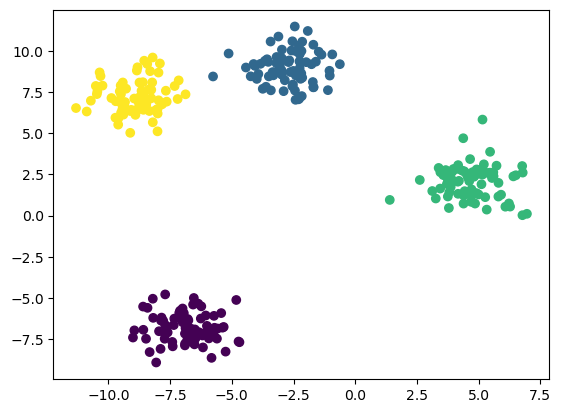

In [83]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# sample data
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=1.0, random_state=42)

# train a model
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

# Use silhouette score to evaluate
silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

# plot the clusters
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
plt.show()

---

# **Consumer 11.1 - Hoeffding Tree**

### Load baseline model

In [101]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "hoef_model_basic_params.json"
params_path = f"{model_folder_path}\\{model_name}"

with open(params_path, 'r') as file:
    loaded_params = json.load(file)

In [102]:
# Initialize the model
hoef_model_baseline_basic = HoeffdingTree()

# Apply the loaded parameters
hoef_model_baseline_basic.set_params(**loaded_params)

HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                        leaf_prediction='nba', max_byte_size=33554432,
                        memory_estimate_period=1000000, nb_threshold=0,
                        no_preprune=False, nominal_attributes=None,
                        remove_poor_atts=False, split_confidence=1e-07,
                        split_criterion='info_gain', stop_mem_management=False,
                        tie_threshold=0.05)

### Variables needed in notebook

In [107]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [100]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, model_description, batch_number,
                                    accuracy_value, precision_value, recall_value, f1_value, 
                                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                                    model_training_time, model_paramaters_json, model_size):
    
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO hoef_basic_rt_model_results
            (model_name, model_id, model_description, batch_number,
                    accuracy_value, precision_value, recall_value, f1_value, 
                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                    model_training_time, model_paramaters_json, model_size) 
            VALUES(%s, %s, %s, %s, %s, %s, %s, %s, 
                    %s, %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, model_description, batch_number,
                    accuracy_value, precision_value, recall_value, f1_value, 
                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                    model_training_time, model_paramaters_json, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")


### Consumer - Isolate Forest - Basic Model

In [11]:
############################################################
# Random Froest Basic and Best Consumer Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500
# set inital model as the saved model # CHANGE THIS EACH MODEL
hoef_model_baseline_basic_current_model = hoef_model_baseline_basic

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                   
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
#         print(f"Loaded features for Batch {i}")
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
#         print(f"Loaded lables for batch {i}")
        
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = hoef_model_baseline_basic_current_model.predict(loaded_features_array)
    
#     # Print predictions for this batch
#     print(f"Predictions for Batch {i}: {predictions}")
#     #print(f"Labels for Batch {i}: {current_labels}")
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"hoef_model_baseline_basic_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "11.4 - Basic Random Forest" 
    
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Basic Hoeffding Tree model with 2500 batches."

    #######################
    # Batch Number - Int
    batch_number = i 

    #######################
    # Accuracy Value - Float
    accuracy_value = float(accuracy_score(current_labels, predictions))
    
    #######################
    # Precision Value - Float
    precision_value = float(precision_score(current_labels, predictions))
    
    #######################
    # Recall Value - Float
    recall_value = float(recall_score(current_labels, predictions))
    
    #######################
    # F1 Value - Float
    f1_value = float(f1_score(current_labels, predictions))
    
    #######################
    # AUC Score - Float
    auc_score = float(roc_auc_score(current_labels, predictions))
    
    #######################
    # ROC Curve - JSON
    fpr, tpr, thresholds = roc_curve(current_labels, predictions)
    roc_curve_data = {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
    ruc_curve_json = json.dumps(roc_curve_data)
    
    #######################
    # Confusion Matrix - JSON
    conf_matrix = confusion_matrix(current_labels, predictions) 
    conf_matrix_list = conf_matrix.tolist()
    confusion_matrix_json = json.dumps(conf_matrix_list)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain model
    #######################

    #######################
    # Combine features and labels # change the format to allow retraining
    combined_features = np.array([list(feature.values()) for feature in current_features])
    combined_labels = np.array(current_labels)

    ####################### CHANGE THIS EACH MODEL
    # Retrain model with combined data from current batch
    start_time = time.time() # start of model training
    hoef_model_baseline_basic_current_model.partial_fit(combined_features, combined_labels)
    end_time = time.time() # end of model training

    #######################
    # Additonal items to save
    #######################
    
    #######################  CHANGE THIS EACH MODEL
    # Model feature importance- JSON
    feature_importance_json = None
    
    #######################
    # New model training time
    model_training_time = end_time - start_time   
    
    #######################
    model_paramaters = hoef_model_baseline_basic_current_model.get_params()
    model_paramaters_json =  json.dumps(model_paramaters)
    # model_paramaters_json = ""
    
    #######################
    
    # Get size
    model_size_bytes = None # didnt retrain
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, model_description, batch_number,
                                    accuracy_value, precision_value, recall_value, f1_value, 
                                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                                    model_training_time, model_paramaters_json, model_size)
    
    print("\n")

NameError: name 'hoef_model_baseline_basic' is not defined

---

# **Consumer 11.1 - SGD SVM**

### Load baseline model

In [24]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "sgb_svm_baseline_model.joblib"

# Load baseline model
sgd_svm_baseline_model = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [38]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [36]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, model_description, batch_number,
                                    accuracy_value, precision_value, recall_value, f1_value, 
                                    confusion_matrix_json, 
                                    model_training_time, model_size):
    
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO sgv_svm_basic_rt_model_results
            (model_name, model_id, model_description, batch_number,
                                    accuracy_value, precision_value, recall_value, f1_value, 
                                    confusion_matrix_json, 
                                    model_training_time, model_size) 
            VALUES(%s, %s, %s, %s, %s, %s, 
                    %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, model_description, batch_number,
                                    accuracy_value, precision_value, recall_value, f1_value, 
                                    confusion_matrix_json, 
                                    model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")


In [39]:
############################################################
# Random Froest Basic and Best Consumer Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500
# set inital model as the saved model # CHANGE THIS EACH MODEL
sgd_svm_baseline_model_current_model = sgd_svm_baseline_model

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                   
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
#         print(f"Loaded features for Batch {i}")
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
#         print(f"Loaded lables for batch {i}")
    
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = sgb_svm_baseline_model_current_model.predict(loaded_features_array)
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"sgv_svm_model_baseline_basic_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "12.4 - SGV SVM Forest" 
    
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "SGV SVM Tree model with 2500 batches."

    #######################
    # Batch Number - Int
    batch_number = i 

    #######################
    # Accuracy Value - Float
    accuracy_value = float(accuracy_score(current_labels, predictions))
    
    #######################
    # Precision Value - Float
    precision_value = float(precision_score(current_labels, predictions))
    
    #######################
    # Recall Value - Float
    recall_value = float(recall_score(current_labels, predictions))
    
    #######################
    # F1 Value - Float
    f1_value = float(f1_score(current_labels, predictions))
    

    #######################
    # Confusion Matrix - JSON
    conf_matrix = confusion_matrix(current_labels, predictions) 
    conf_matrix_list = conf_matrix.tolist()
    confusion_matrix_json = json.dumps(conf_matrix_list)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain model
    #######################

    #######################
    # Combine features and labels # change the format to allow retraining
    combined_features = np.array([list(feature.values()) for feature in current_features])
    combined_labels = np.array(current_labels)
    
#     print(type(combined_features))
#     print(type(combined_labels))
#     print(combined_features)
#     print(combined_labels)
#     print(combined_features.dtype)
#     print(combined_labels.dtype)
#     print(combined_features.shape)
#     print(combined_labels.shape)
#     print(np.any(np.isnan(combined_features)), np.any(np.isinf(combined_features)))
#     print(np.any(np.isnan(combined_labels)), np.any(np.isinf(combined_labels)))
    combined_features = combined_features.astype(np.float32)
    combined_labels = combined_labels.astype(np.int32)
    
    ####################### CHANGE THIS EACH MODEL
    # Retrain model with combined data from current batch
    start_time = time.time() # start of model training
    sgb_svm_baseline_model_current_model.partial_fit(combined_features, combined_labels)
    end_time = time.time() # end of model training

    #######################
    # Additonal items to save
    #######################
    
    #######################
    # New model training time
    model_training_time = end_time - start_time   
    
    #######################
    
    # Get size
    model_size = None # didnt retrain
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, model_description, batch_number,
                                    accuracy_value, precision_value, recall_value, f1_value, 
                                   confusion_matrix_json,
                                    model_training_time, model_size)
    
    print("\n")

Processing Batch 0
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 3
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 4
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 5
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 6
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 7
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 8
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 9
The model results have been

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 78
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 79
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 80
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 81
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 82
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 83
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 84
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 85
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 86
The model results have been inserted 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 155
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 156
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 157
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 158
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 159
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 160
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 161
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 162
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 163
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 231
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 232
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 233
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 234
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 235
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 236
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 237
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 238
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 239
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 307
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 308
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 309
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 310
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 311
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 312
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 313
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 314
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 315
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 383
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 384
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 385
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 386
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 387
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 388
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 389
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 390
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 391
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 459
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 460
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 461
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 462
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 463
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 464
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 465
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 466
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 467
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 535
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 536
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 537
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 538
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 539
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 540
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 541
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 542
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 543
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 611
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 612
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 613
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 614
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 615
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 616
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 617
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 618
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 619
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 687
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 688
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 689
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 690
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 691
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 692
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 693
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 694
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 695
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 763
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 764
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 765
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 766
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 767
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 768
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 769
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 770
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 771
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 839
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 840
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 841
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 842
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 843
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 844
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 845
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 846
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 847
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 915
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 916
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 917
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 918
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 919
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 920
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 921
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 922
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 923
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 991
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 992
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 993
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 994
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 995
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 996
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 997
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 998
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 999
The model results have been 

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1067
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1068
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1069
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1070
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1071
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1072
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1073
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1074
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1075
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1143
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1144
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1145
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1146
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1147
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1148
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1149
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1150
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1151
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1219
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1220
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1221
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1222
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1223
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1224
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1225
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1226
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1227
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1295
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1296
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1297
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1298
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1299
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1300
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1301
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1302
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1303
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1371
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1372
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1373
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1374
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1375
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1376
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1377
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1378
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1379
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1447
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1448
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1449
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1450
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1451
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1452
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1453
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1454
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1455
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1523
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1524
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1525
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1526
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1527
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1528
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1529
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1530
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1531
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1599
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1600
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1601
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1602
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1603
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1604
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1605
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1606
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1607
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1675
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1676
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1677
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1678
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1679
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1680
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1681
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1682
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1683
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1751
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1752
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1753
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1754
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1755
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1756
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1757
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1758
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1759
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1827
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1828
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1829
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1830
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1831
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1832
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1833
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1834
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1835
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1903
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1904
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1905
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1906
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1907
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1908
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1909
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1910
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1911
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1979
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1980
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1981
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1982
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1983
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1984
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1985
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1986
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 1987
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2055
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2056
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2057
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2058
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2059
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2060
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2061
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2062
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2063
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2131
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2132
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2133
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2134
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2135
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2136
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2137
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2138
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2139
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2207
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2208
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2209
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2210
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2211
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2212
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2213
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2214
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2215
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2283
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2284
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2285
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2286
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2287
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2288
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2289
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2290
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2291
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2359
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2360
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2361
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2362
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2363
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2364
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2365
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2366
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2367
The model results h

The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2435
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2436
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2437
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2438
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2439
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2440
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2441
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2442
The model results have been inserted successfully
The Conneciton to MySQL is closed.


Processing Batch 2443
The model results h